# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1580]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_150)

Anyone can do hot, but this sauce also tastes great! Most hot sauces taste like vinegar, but this one tastes like fresh peppers. It's got great kick, so a little goes a long way. My grocery stopped selling it, so I've had to venture online to find it.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Anyone can do hot, but this sauce also tastes great! Most hot sauces taste like vinegar, but this one tastes like fresh peppers. It is got great kick, so a little goes a long way. My grocery stopped selling it, so I have had to venture online to find it.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Anyone can do hot but this sauce also tastes great Most hot sauces taste like vinegar but this one tastes like fresh peppers It is got great kick so a little goes a long way My grocery stopped selling it so I have had to venture online to find it 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 126357/126357 [01:53<00:00, 1116.25it/s]


In [23]:
preprocessed_reviews[1890]

'stop going bring baking materials cake way best cake ever long nielsen massey vanilla one ingredients used almost every type real vanilla years none better one taste fits needs perfectly eat end result agree even though cheap imitation vanilla readily available low cost per unit real vanilla also readily available one absolute best thought ounce size would much might not get used expiring plain wrong gone long expiration consumers house say thank nothing quite pleasant one church ladies guest extolling goodness pound cake made nielsen know vanilla insignificant part total product one element adds much flavor goodness'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similarly you can do preprocessing for review summary also.
#here i will be preprocessing the summary data
#let us print some random summary rows here
sum1=final['Summary'].values[0]
print(sum1)
print("*"*60)

sum2=final['Summary'].values[100]
print(sum2)
print("*"*60)

sum3=final['Summary'].values[550]
print(sum3)
print("*"*60)

sum4=final['Summary'].values[11550]
print(sum4)
print("*"*60)

sum5=final['Summary'].values[9170]
print(sum5)
print("*"*60)
#below I have successfully printed some of the summary text

Love the book, miss the hard cover version
************************************************************
Very happy
************************************************************
The absolute best treats for small dogs!
************************************************************
I've liked every kind that I've tried
************************************************************
Great deal - swim fast!
************************************************************


In [25]:
final.Summary.head(10)

138688           Love the book, miss the hard cover version
138699                                    good for children
138698                                             Darling!
138696                               Chicken soup with Rice
138695                                            A classic
138686                               Chicken Soup with Rice
138676    Read it once. Read it twice. Reading Chicken S...
138677                                      Family favorite
138678              You'll use it once, you'll use it twice
138679    The story is great, the softcover book is disa...
Name: Summary, dtype: object

In [26]:
#so let's remove those punctuation marks first
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
#sum1=re.sub(r"?","",sum1)

import string
#sum1.translate(None,string.punctuation)
#https://stackoverflow.com/questions/23175809/str-translate-gives-typeerror-translate-takes-one-argument-2-given-worked-i
sum5 = sum5.translate(str.maketrans('','',string.punctuation))
print(sum5)

Great deal  swim fast


In [27]:
#there is no need to parse the summary section using beautifulsoup because there are no html tags in summary section
sum2= sum2.translate(str.maketrans('','',string.punctuation))
print(sum2)
#so the above punctuation remover seems to be working fine

Very happy


In [28]:
#let's check again if there are any summary where they have used short words
sum_rev=final['Summary'].values[1179:1230]
print(sum_rev)
#unfortunately we cannot search randomly and find the summary that has a short word, so let's take a subset randomly and we can see 
#that most of the summary does not have short words and filter for them are already covered in the review section

['Great looking bonsai but had a few wire marks!'
 'pot was cracked when I received it!!' 'Awsome'
 'I understand advertising, but this is not quite up to par.'
 'Very pleased with Chinese Elm Bonsai - Looks beautiful !'
 'Got a lot of haters of out little tree...' 'A good thing it was a gift'
 'The pot was broken and the soil was all over the box' 'very good'
 '6 years later...' 'Wrong tree and pot and grown improperly'
 'great product - even greater vendor' 'worst amazon experience ever!'
 'Not sure about this one!' 'ugly!!'
 'horrific looked like they had just found a twig and loped off the top!'
 'Healthy tree and packaged well'
 "Nice looking tree but it didn't live long"
 'Died, in spite of best efforts' 'Made a great gift!!' 'Really?'
 'misleading, inaccurate, poor choice for sympathy gift'
 'Great Customer Service!' 'A Little Taste of Heaven' 'BONSAI OBSESSION'
 'Beautiful' 'Perfect' 'Gift of bonsai tree'
 "Very Large Bonsai! It's Beautiful."
 'Excellent Starter Tree at Any Pri

In [29]:
# https://stackoverflow.com/a/47091490/4084039
#with minor modification we can just utilize the same function that was used for the review phrase

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'em", " them", phrase)
    return phrase

In [30]:
#check a random summary
new_sum=decontracted(final['Summary'].values[11000])
print(new_sum)

Great herbal tea


# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (126357, 66460)
the number of unique words  66460


## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (126357, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abide', 'abilities']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (126357, 74310)
the number of unique words including both unigrams and bigrams  74310


## [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8458716869354248), ('awesome', 0.8397884368896484), ('good', 0.837662935256958), ('terrific', 0.8192715644836426), ('excellent', 0.819176435470581), ('wonderful', 0.774000883102417), ('perfect', 0.7584977746009827), ('fabulous', 0.7241874933242798), ('nice', 0.7071027159690857), ('amazing', 0.6864328980445862)]
[('greatest', 0.8215168118476868), ('best', 0.7230428457260132), ('tastiest', 0.7158358097076416), ('nastiest', 0.6943908333778381), ('smoothest', 0.6596178412437439), ('terrible', 0.6498016119003296), ('disgusting', 0.6487202644348145), ('horrible', 0.6340863108634949), ('coolest', 0.6269861459732056), ('closest', 0.6163842082023621)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  20660
sample words  ['grew', 'reading', 'sendak', 'books', 'watching', 'really', 'rosie', 'movie', 'incorporates', 'love', 'son', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes', 'two', 'hands', 'keep', 'pages', 'open', 'classic', 'children', 'book', 'not', 'go', 'wrong', 'read', 'kid', 'ordered', 'later', 'beat', 'author', 'wrote', 'wild', 'things', 'carol', 'king', 'great', 'song', 'matches', 'lyrics', 'illustrations', 'fabulous', 'wish']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 126357/126357 [12:25<00:00, 169.42it/s]


126357
50


#### [4.4.1.2] TFIDF weighted W2v

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
from tqdm import tqdm_notebook as tqdm
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

A Jupyter Widget

In [47]:
final["cleaned_text"] = preprocessed_reviews

In [48]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [49]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [50]:
cleaned_data.shape

(126357, 12)

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [51]:
# Please write all the code with proper documentation
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# Fuction to compute alpha value
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(0.0001,1 ,0.001)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'roc_auc')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]
# determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(np.log2(alpha_values), MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [52]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# 100k data which will use to train model after vectorization
X = final["cleaned_text"]
print("shape of X:", X.shape)

shape of X: (126357,)


In [53]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# class label
y = final["Score"]
print("shape of y:", y.shape)

shape of y: (126357,)


In [54]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(88449,) (88449,) (37908,)


In [55]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<88449x55882 sparse matrix of type '<class 'numpy.int64'>'
	with 2923742 stored elements in Compressed Sparse Row format>

In [56]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [57]:
x_test.shape

(37908, 55882)


The optimal number of alpha is 0.


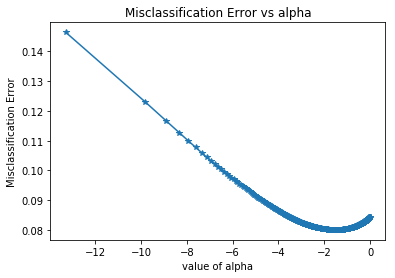

0.3511

In [58]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# To choose optimal_alpha using cross validation
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [59]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)


In [60]:
# To get all the features name 

bow_features = bow.get_feature_names()

In [61]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 55882)

In [62]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([13993., 74456.])

In [63]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.4906415 , -14.392209  , -14.392209  , ..., -14.392209  ,
        -14.392209  , -13.04460573],
       [-11.91485522, -13.20030234, -13.66831583, ..., -14.57668541,
        -14.57668541, -14.57668541]])

In [64]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(55882, 2)

In [65]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.931158068491447


In [66]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.068842%


In [67]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# evaluate accuracy on test data
from sklearn.metrics import accuracy_score
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))


The accuracy of the naive bayes classifier for alpha = 0 is 90.819880%


In [68]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 4210,  1828],
       [ 1652, 30218]], dtype=int64)

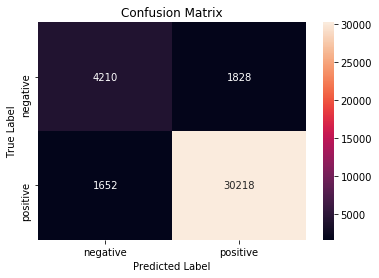

In [69]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [70]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.72      0.70      0.71      6038
          1       0.94      0.95      0.95     31870

avg / total       0.91      0.91      0.91     37908



### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [71]:
# Please write all the code with proper documentation
print("Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Positive Features:-
 not       -3.724110
like      -4.534851
good      -4.683077
great     -4.749041
one       -4.879064
coffee    -4.946193
taste     -4.968764
flavor    -5.066981
love      -5.071766
product   -5.078070
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -3.299655
like      -4.411419
would     -4.679334
taste     -4.688856
product   -4.704637
one       -4.903411
coffee    -5.056902
good      -5.139391
no        -5.167630
flavor    -5.237398
Name: 0, dtype: float64


In [73]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
from sklearn.naive_bayes import MultinomialNB
def nb_all(train,test,cv):
    #Calculation NB for different k values
    auc_train = []
    auc_cv = []
    a = np.arange(0.0001,2,0.001)
    print("Starting classifier...")
    for i in tqdm(a):
        NB = MultinomialNB(alpha=i)
        NB.fit(train,y_train)

        pred_prob = NB.predict_proba(cv)
        pred_prob_train = NB.predict_proba(train)

        #acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
        auc_cv.append(roc_auc_score(y_cv, pred_prob[:,1]))
        auc_train.append(roc_auc_score(y_train, pred_prob_train[:,1]))

    #Plotting the AUC curve for train and test data

    #Print the graph

    plt.plot(a,auc_train,'r', label = 'Train Data')
    plt.plot(a,auc_cv,'b', label = 'CV Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data\n")
    plt.xlabel("Hyper Parameter(alpha)")
    plt.ylabel("AUC Value")
    plt.show()


    #Get k value for max auc in cv data
    mx = 0
    for i in range(len(auc_cv)):
        if(auc_cv[i]> auc_cv[mx]):
            mx = i
    opt = a[mx] 
    print("The optimal value of alpha = ", opt)

    #print("\nClassifying Test Data\n\n")
    NB = MultinomialNB(alpha=opt)
    NB.fit(train,y_train)
    pred_prob = NB.predict_proba(test)

    print("\nThe AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
    
    #Get k value for max auc in cv data
    print("\nClassifying Test Data\n\n")
    

    #pred = NB.predict(test)
    pred_prob = NB.predict_proba(test)

    #pred_train = NB.predict(X_train_vec)
    pred_prob_train = NB.predict_proba(train)

    #ROC Values comutation
    fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
    fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
    print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))

    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

In [77]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [78]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(84659,) (84659,)
(27938,) (27938,)
(41698,) (41698,)
After vectorizations
(84659, 54423) (84659,)
(27938, 54423) (27938,)
(41698, 54423) (41698,)


Starting classifier...


A Jupyter Widget

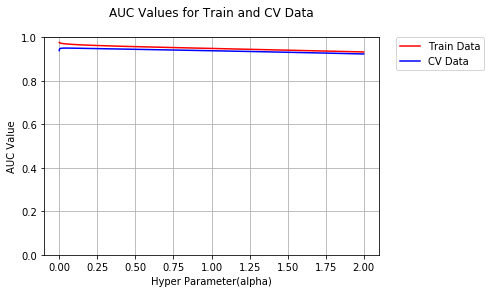

The optimal value of alpha =  0.0441

The AUC value for test data is  0.9093863904011185

Classifying Test Data


The AUC value for test data is  0.9093863904011185


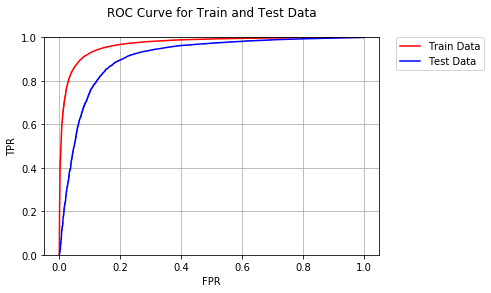

In [79]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
from sklearn. metrics import roc_auc_score

nb_all(X_train_bow,X_test_bow,X_cv_bow)

<h3>Conclusion for bow</h3>

<b>Observations:</b><br>
1.The optimal value of alpha is 0.0441.<br> 
2.Auc values for train and CV data can be seen as closely overlapping on each other. And they are close to value of 1.0 which is good.<br>
3.As I tested our model on unseen data(test data) the accuracy is 90.81% when alpha is=0<br>
4.In confusion matrix, It is clear that predicted +ve and true +ve is 30218.Which seems to be a good number.<br>
5.In a nutshell we can say the generalization error is low means this model works well with unseen data. And area under the curve is large enough<br>

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [87]:
# Please write all the code with proper documentation
# data
X = final["cleaned_text"]

In [88]:
# Target/class-label
y = final["Score"]

In [89]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(88449,) (37908,) (88449,) (37908,)


In [90]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=500)
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<88449x500 sparse matrix of type '<class 'numpy.float64'>'
	with 1693820 stored elements in Compressed Sparse Row format>

In [91]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(37908, 500)


The optimal number of alpha is 0.


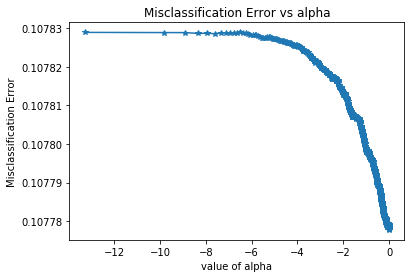

0.9981

In [92]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# To choosing optimal_alpha
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

<b>Observations:</b><br>
1.The above graph seems to be less efficient in predicting the optimal alpha and it takes lot of time in doing so. Thus I shall implement another method to predict a efficient and optimal alpha.

In [102]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
from sklearn.naive_bayes import MultinomialNB
def nb_all(train,test,cv):
    #Calculation NB for different k values
    auc_train = []
    auc_cv = []
    a = np.arange(0.0001,2,0.001)
    print("Starting classifier...")
    for i in tqdm(a):
        NB = MultinomialNB(alpha=i)
        NB.fit(train,y_train)

        pred_prob = NB.predict_proba(cv)
        pred_prob_train = NB.predict_proba(train)

        #acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
        auc_cv.append(roc_auc_score(y_cv, pred_prob[:,1]))
        auc_train.append(roc_auc_score(y_train, pred_prob_train[:,1]))

    #Plotting the AUC curve for train and test data

    #Print the graph

    plt.plot(a,auc_train,'r', label = 'Train Data')
    plt.plot(a,auc_cv,'b', label = 'CV Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data\n")
    plt.xlabel("Hyper Parameter(alpha)")
    plt.ylabel("AUC Value")
    plt.show()


    #Get k value for max auc in cv data
    mx = 0
    for i in range(len(auc_cv)):
        if(auc_cv[i]> auc_cv[mx]):
            mx = i
    opt = a[mx] 
    print("The optimal value of alpha = ", opt)

    #print("\nClassifying Test Data\n\n")
    NB = MultinomialNB(alpha=opt)
    NB.fit(train,y_train)
    pred_prob = NB.predict_proba(test)

    print("\nThe AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
    
    #Get k value for max auc in cv data
    print("\nClassifying Test Data\n\n")
    

    #pred = NB.predict(test)
    pred_prob = NB.predict_proba(test)

    #pred_train = NB.predict(X_train_vec)
    pred_prob_train = NB.predict_proba(train)

    #ROC Values computation
    fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
    fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
    print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))

    plt.plot(fpr,tpr,'r', label = 'Train Data')
    plt.plot(fpr1,tpr1,'b', label = 'Test Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("ROC Curve for Train and Test Data\n")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

In [103]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [117]:
#https://github.com/omkar1610/Amazon-Fine-Food-Reviews/blob/master/04%20Amazon%20Fine%20Food%20Reviews%20Analysis_NaiveBayes_Adding%20new%20Features.ipynb
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

(84659,) (84659,)
(27938,) (27938,)
(41698,) (41698,)
After vectorizations
(84659, 500) (84659,)
(27938, 500) (27938,)
(41698, 500) (41698,)


Starting classifier...


A Jupyter Widget

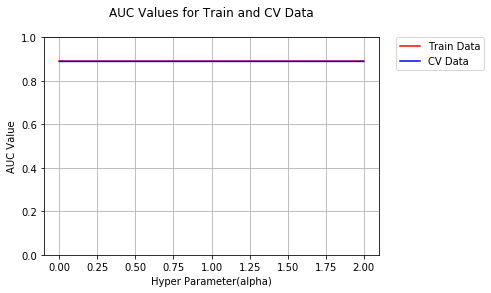

The optimal value of alpha =  1.8561

The AUC value for test data is  0.8849976063298092

Classifying Test Data


The AUC value for test data is  0.8849976063298092


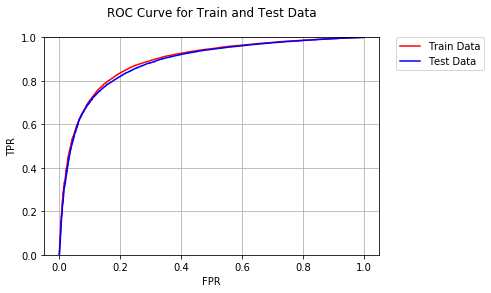

In [118]:
# Please write all the code with proper documentation
nb_all(X_train_tfidf,X_test_tfidf,X_cv_tfidf)

In [119]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = 1.8561)

# fitting the model
nb_optimal.fit(X_train_tfidf, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = nb_optimal.predict(X_test_tfidf)

In [120]:
# To get all the features name 
tfidf_features = tf_idf_vect.get_feature_names()

In [121]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting
feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 500)

In [122]:
# Number of samples encountered for each class during fitting
nb_optimal.class_count_

array([13414., 71245.])

In [123]:
# Empirical log probability of features given a class(i.e. P(x_i|y))
log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-6.96315739, -6.91358956, -6.16012092, -6.55226129, -6.55648199,
        -7.4849343 , -6.72918272, -6.87796227, -6.00981015, -5.31963983,
        -7.84884619, -6.92881723, -6.66824117, -8.20599616, -4.95188787,
        -6.55859903, -5.90639264, -6.61527685, -6.07297393, -7.25205123,
        -6.55436941, -6.45788122, -6.63796096, -7.03559174, -7.15514508,
        -5.74938468, -8.59046238, -6.69946698, -5.65749901, -5.23605472,
        -5.44020044, -6.09940057, -6.7676139 , -6.54805833, -6.51708691,
        -7.21460241, -6.81030343, -6.10746669, -5.29837996, -6.29714294,
        -6.25559387, -7.07743066, -6.28740033, -6.58871816, -6.85775117,
        -7.56281364, -6.30369115, -5.20931003, -7.47959686, -5.15214722,
        -6.40926044, -5.72147215, -6.72918272, -7.52311601, -7.58032149,
        -7.45852749, -6.98564063, -6.49895427, -4.9677384 , -5.95155437,
        -7.55704515, -7.23523394, -6.75722031, -6.34390727, -6.60857075,
        -7.34066112, -6.7546387 , -6.3822491 , -6.9

In [124]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(500, 2)

In [128]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_train_tfidf, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.876811679797777


In [129]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.123188%


In [130]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, acc_tfidf))


The accuracy of the naive bayes classifier for alpha = 0 is 87.301549%


In [131]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 3656,  2961],
       [ 2334, 32747]], dtype=int64)

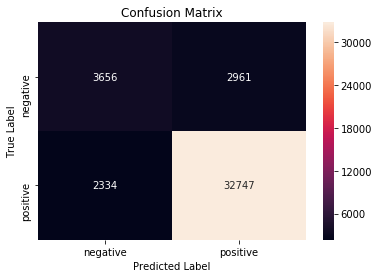

In [132]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [133]:
# Please write all the code with proper documentation
# To show top 10 feature from both class
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])



 Top 10 positive features:-
 not get       -3.213951
liked         -4.030919
granola       -4.169361
green tea     -4.240302
often         -4.383018
cold          -4.433562
tastes like   -4.453265
flavored      -4.564051
loves         -4.568333
would not     -4.579881
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [134]:
# Please write all the code with proper documentation
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])

Top 10 negative features:-
 not get       -2.706082
liked         -3.817610
would not     -4.101342
problems      -4.112663
tastes like   -4.121701
often         -4.312177
cold          -4.461562
granola       -4.552798
not           -4.582021
flavored      -4.613639
Name: 0, dtype: float64


In [135]:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.61      0.55      0.58      6617
          1       0.92      0.93      0.93     35081

avg / total       0.87      0.87      0.87     41698



<h3>Conclusion for tfidf</h3>

<b>Observations:</b><br>
1.The precision,recall and the f-1 score is quite good.<br>
2.As in "naive baiyes with tfidf" when alpha = 1.8561 the accuracy is quite better than bow implementation. In this model, train_error is low around 12%<br>
3.We saw a decrease in accuracy rate by almost 3% when switched with tfidf.<br>
4.After printing top feature from both class we found that features words like not,like etc. are used as both in the positive features.

In [136]:
# Please compare all your models using Prettytable library
#!/usr/bin/python3

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["BOW","Brute", 0.0441, 0.9093])
x.add_row(["TFIDF","Brute", 1.8561, 0.8849])

print(x)

+------------+-------+-----------------+--------+
| Vectorizer | Model | Hyper Parameter |  AUC   |
+------------+-------+-----------------+--------+
|    BOW     | Brute |      0.0441     | 0.9093 |
|   TFIDF    | Brute |      1.8561     | 0.8849 |
+------------+-------+-----------------+--------+


# [6] Conclusions

1.Naive bayes are good at text classification task like spam filtering, sentimental analysis, RS etc.<br>
2.Initially bow is a good model for understanding how the train and test data performs. As we know when a model performs good on training data but poor performance on unseen data(test data)i.e. its dependent on training data only, tends to overfit and when a model perform poor performance on training data and good performance on test data i.e. it fails to learn relationship in training data then it tends to underfit the model. We need to balance between both i.e. reduce training error and balance error between both training and testing which is balanced in this case.<br>
3.Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend to underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where both models have low training error and test error.<br>
4.Overall, both of the models are performing well on unseen data.<br>
5.As we are not applying naive bayes on word2vec representation because it sometimes gives -ve value(i.e. if two word have 0 cosine similarity the word is completly orthogonal i.e. they are not related with each other. and 1 represents perfect relationship between word vector. whereas -ve similarity means they are perfect opposite relationship between word) and we know naive bayes assume that presence of a particular feature in a class is unrelated to presence of any other feature, which is most unlikely in real word. Although, it works well.<br>
6.And from point # 5, features are dependent or there are relationship between features. So applying naive bayes on dependent feature does not make any sense.
